In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# The Ass1stant D: a personalized meal planner for T1D Patients

This notebook showcases a GenAI-powered assistant that helps build **personalized meal plans** for people with T1D. It leverages glucose data, medical guidelines, and AI-generated recipe analysis to offer tailored nutrition strategies.

⚠️ **Disclaimer:** This notebook demonstrates an AI agent concept for educational purposes related to Type 1 Diabetes management. It is **NOT** a medical device or a substitute for professional medical advice, diagnosis, or treatment. Always seek the advice of your physician or other qualified health provider with any questions you may have regarding a medical condition. Never disregard professional medical advice or delay in seeking it because of something you have read in this notebook.

## Understanding Type 1 Diabetes Management Challenges
Type 1 Diabetes (T1D) is an autoimmune condition where the pancreas produces little to no insulin, requiring patients to manually regulate their blood glucose through insulin therapy and dietary management.  
This presents several key challenges: 
1. **Complex Meal Planning**: Every meal must be carefully balanced to avoid blood glucose spikes or dangerous lows
2. **Individual Variability**: Each patient has unique insulin sensitivity, dietary preferences, and glucose patterns
3. **Continuous Adaptation**: Management strategies must evolve based on changing glucose patterns, activity levels, and physiological changes
Traditional static meal plans fail to address these dynamic needs, often leading to suboptimal glucose control. A one-size-fits-all approach is inadequate for T1D management.

## How GenAI Creates a Personalized Solution
This notebook demonstrates an AI agent that leverages large language models to create highly personalized meal plans for T1D patients by:
1. **Analyzing Individual Data**: Processing glucose patterns and patient profiles to identify specific needs
2. **Retrieving Expert Knowledge**: Using vector embeddings to access relevant medical guidelines based on patient characteristics
3. **Generating Personalized Recommendations**: Creating tailored meal plans that address the patient's specific glucose patterns
4. **Explaining Recommendations**: Providing clear rationales connecting meal choices to glucose management strategies

## Code Structure
- **Data Analysis Module**: Processes glucose readings to identify patterns (dawn phenomenon, post-meal spikes, etc.)
- **Knowledge Retrieval System**: Uses vector DB and embeddings to access relevant T1D guidelines
- **Recipe Generation**: Creates personalized meal plans aligned with medical guidelines
- **Explanation Engine**: Provides clear connections between meal recommendations and glucose management

## Setup and dependencies

In [2]:
!pip install -U -q "google-genai==1.7.0"

from google import genai
from google.genai import types

from kaggle_secrets import UserSecretsClient
GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 3.7 MB/s eta 0:00:00


In [3]:
genai.__version__

'1.7.0'

In [4]:
!pip uninstall -qqy jupyterlab  # Remove unused conflicting packages

In [5]:
!pip install -q chromadb matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.4/188.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 3.7 MB/s eta 0:00:0

In [6]:
import pandas as pd
import numpy as np
from typing import List, Dict, Any, Optional, Tuple
import json
import logging
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime, timedelta
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import chromadb
from chromadb import Documents, EmbeddingFunction, Embeddings

In [7]:
client = genai.Client(api_key=GOOGLE_API_KEY)

In [8]:
# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

## Vector database (T1D guidelines)
This section creates a vector database of T1D management guidelines using ChromaDB. This approach allows us to:

1. **Store Medical Knowledge**: Guidelines for different age groups, glucose patterns, and weight considerations
2. **Enable Semantic Search**: Find the most relevant guidelines based on patient characteristics  
3. **Support Contextual Retrieval**: Provide the LLM with only the most pertinent medical information
 
The embedding function uses Gemini's embedding model to convert text guidelines into vector representations, allowing for semantic similarity search. This form of knowledge retrieval ensures the agent provides medically appropriate advice based on established guidelines rather than hallucinating recommendations.

**IMPORTANT: We are using sample guidelines here! They do not contain verified medical information!!!**

In [9]:
documents = [
    """
    Pediatric T1D Management (Ages 0-12)
    Blood glucose targets: 90-180 mg/dL before meals, 100-180 mg/dL at bedtime
    Insulin requirements: 0.5-0.8 units/kg/day during honeymoon phase; 0.7-1.0 units/kg/day post-honeymoon
    Hypoglycemia management: Treat with 0.3g/kg of fast-acting carbohydrates for BG < 70 mg/dL
    Recommended monitoring: Minimum 6-10 checks daily, CGM preferred
    Physical activity: Additional carbohydrate intake of 10-15g per 30 minutes of moderate activity
    """,
    
    """
    Adolescent T1D Management (Ages 13-18)
    Blood glucose targets: 90-130 mg/dL before meals, 90-150 mg/dL at bedtime
    Insulin requirements: 0.8-1.2 units/kg/day, may require higher doses during puberty
    Recommended monitoring: Minimum 4-6 checks daily, CGM strongly recommended
    Dawn phenomenon management: Consider increased basal rates by 10-20% between 4-8 AM
    Weight-based considerations: BMI monitoring every 3 months, insulin sensitivity factor typically 1800/total daily dose
    """,
    
    """
    Adult T1D Management (Ages 19-64)
    Blood glucose targets: 80-130 mg/dL before meals, 90-150 mg/dL at bedtime, A1C < 7.0%
    Insulin requirements: 0.5-1.0 units/kg/day, adjust based on activity level and insulin sensitivity
    Dawn phenomenon: Consider increased basal rates by 10-30% between 3-7 AM or switching to pump therapy
    Weight considerations: For every 10% over ideal body weight, reduce insulin sensitivity factor by 10%
    Gender considerations: Women may require insulin adjustments during menstrual cycle (typically 20-30% increase during luteal phase)
    """,
    
    """
    Elderly T1D Management (Ages 65+)
    Blood glucose targets: 100-180 mg/dL before meals, 100-200 mg/dL at bedtime, A1C < 8.0%
    Insulin requirements: Typically lower, 0.4-0.8 units/kg/day due to reduced renal function
    Hypoglycemia risk: Higher risk, consider less aggressive targets and more frequent monitoring
    Weight considerations: Sarcopenia may increase insulin sensitivity; lower doses recommended for BMI < 22
    Comorbidity considerations: Adjust management based on cardiovascular, renal, and cognitive status
    """,
    
    """
    Managing Dawn Phenomenon in T1D
    Definition: Morning hyperglycemia due to counterregulatory hormones (growth hormone, cortisol) between 4-8 AM
    Identification: Consistently elevated morning glucose readings despite normal bedtime readings
    Management strategies:
    - Basal insulin adjustment: Increase overnight basal by 10-20% or adjust pump basal rates between 3-7 AM
    - Timing adjustment: Move long-acting insulin from dinner to bedtime
    - Technology solutions: Consider closed-loop insulin pump systems with predictive algorithms
    - Dietary considerations: Avoid high-fat or high-protein meals before bed
    """,
    
    """
    Weight-Based T1D Management Guidelines
    Underweight (BMI < 18.5): Insulin sensitivity typically higher, ISF often 1 unit per 80-100 mg/dL
    Normal weight (BMI 18.5-24.9): Standard insulin calculation factors apply
    Overweight (BMI 25-29.9): Decrease ISF by 10-20%, insulin requirements may be higher
    Obese (BMI ≥ 30): Decrease ISF by 20-40%, significant insulin resistance may be present
    Weight-based starting TDD calculation: 0.55 × weight(kg) for adults, 0.75 × weight(kg) for adolescents
    For insulin pump users: Approximate basal needs are 40-50% of TDD
    """
]

## Embedding Function for Medical Knowledge

The embedding function below uses Gemini's embedding model to convert our T1D guidelines into vector representations. This is crucial because:
 
1. It transforms medical text into numerical vectors that capture semantic meaning
2. It enables similarity-based retrieval to find the most relevant guidelines
3. It allows us to match patient characteristics to appropriate medical guidelines 

The model is specifically configured for document retrieval tasks to optimize for finding relevant medical information.

In [10]:
class GeminiEmbeddingFunction(EmbeddingFunction):
  def __call__(self, input: Documents) -> Embeddings:
    EMBEDDING_MODEL_ID = "models/embedding-001"  # @param ["models/embedding-001", "models/text-embedding-004", "models/gemini-embedding-exp-03-07", "models/gemini-embedding-exp"] {"allow-input": true, "isTemplate": true}
    title = "Custom query"
    response = client.models.embed_content(
        model=EMBEDDING_MODEL_ID,
        contents=input,
        config=types.EmbedContentConfig(
          task_type="retrieval_document",
          title=title
        )
    )

    return response.embeddings[0].values

## Building the T1D Knowledge Database

The functions below create and query our vector database of T1D guidelines. This approach enables:

1. **Context-aware retrieval**: Finding guidelines that match the patient's specific situation
2. **Relevance ranking**: Prioritizing the most applicable medical knowledge
3. **Prompt engineering**: Creating medically informed prompts for the LLM

This retrieval-augmented generation (RAG) approach ensures our meal recommendations are grounded in established medical guidelines.

In [11]:
# Create ChromaDB collection
def create_t1d_guidelines_db(documents, name="t1d_guidelines_db"):
    """
    Create a vector database of T1D guidelines for similarity search
    
    Args:
        documents: List of T1D guideline texts
        name: Name for the ChromaDB collection
        
    Returns:
        ChromaDB collection with embedded guidelines
    """
    chroma_client = chromadb.Client()
    existing_collections = [c.name for c in chroma_client.list_collections()]
    if name in existing_collections:
        chroma_client.delete_collection(name=name)
    else:
        db = chroma_client.create_collection(
            name=name,
            embedding_function=GeminiEmbeddingFunction()
        )
    
    for i, doc in enumerate(documents):
        db.add(
            documents=doc,
            ids=f"doc_{i}",
        )
    return db

# Retrieve relevant passages based on patient data
def get_relevant_passages(patient_data, db, n_results=2):
    """
    Find the most relevant T1D guidelines for a specific patient
    
    Args:
        patient_data: Dictionary with patient information
        db: ChromaDB collection with T1D guidelines
        n_results: Number of relevant passages to retrieve
        
    Returns:
        List of relevant guideline passages
    """
    # Create a composite query string from patient data
    age = patient_data['age']
    age_group = ""
    
    if age < 13:
        age_group = "pediatric child"
    elif 13 <= age <= 18:
        age_group = "adolescent teen"
    elif 19 <= age <= 64:
        age_group = "adult"
    else:
        age_group = "elderly senior"
    
    query = f"{age_group} {patient_data['sex']} T1D patient weight {patient_data['weight']}kg with {patient_data['glucose_pattern']}"
    
    # Retrieve the most relevant passages
    results = db.query(query_texts=[query], n_results=n_results)
    return results['documents'][0]

## Prompt Engineering for Medical Guidance

This section demonstrates how to craft effective prompts that combine:
1. **Patient-specific data**: Demographics, glucose patterns, and preferences
2. **Relevant medical guidelines**: Retrieved from our vector database
3. **Clear instructions**: To ensure medically appropriate responses

The prompts follow a consistent structure:
- Context setting (role of the AI)
- Inclusion of retrieved medical knowledge
- Patient-specific data points
- Clear question formulation
- Guardrails to prevent hallucination

This structured approach ensures the model generates responses that adhere to medical best practices while being tailored to the individual patient.

In [12]:
GENERATION_MODEL_NAME = "gemini-2.0-flash"

In [13]:
# Create prompt for Gemini API
def make_t1d_prompt(patient_data, relevant_passages):
    """
    Create a structured prompt combining patient data and relevant T1D guidelines
    
    Args:
        patient_data: Dictionary with patient information
        relevant_passages: Retrieved medical guideline passages
        
    Returns:
        Formatted prompt for the LLM
    """
    escaped_passages = [p.replace("'", "").replace('"', "").replace("\n", " ") for p in relevant_passages]
    passages_text = "\n".join([f"PASSAGE {i+1}: '{p}'" for i, p in enumerate(escaped_passages)])
    
    prompt = f"""
    You are a healthcare AI assistant trained to provide information about Type 1 Diabetes management guidelines.
    Answer based solely on the reference passages included below.
    Be comprehensive but clear, and avoid medical jargon when possible.
    If the passages don't contain relevant information to answer the question, acknowledge the limitations.
    Do not make up information not contained in the passages.
    
    PATIENT: {patient_data['age']} year old {patient_data['sex']}, weighing {patient_data['weight']}kg
    GLUCOSE PATTERN: {patient_data['glucose_pattern']}
    QUESTION: '{patient_data['question']}'
    
    {passages_text}
    
    ANSWER:
    """
    
    return prompt

# Generate response from Gemini
def get_t1d_guidance(patient_data, db):
    """
    Generate personalized T1D guidance based on patient data and medical guidelines
    
    Args:
        patient_data: Dictionary with patient information
        db: ChromaDB collection with T1D guidelines
        
    Returns:
        Personalized guidance text
    """
    # Get relevant passages
    relevant_passages = get_relevant_passages(patient_data, db)
    
    # Create prompt
    prompt = make_t1d_prompt(patient_data, relevant_passages)
    
    # Generate response
    response = client.models.generate_content(
        model=GENERATION_MODEL_NAME,
        contents=prompt
    )
    
    return response.text

In [14]:
chroma_client = chromadb.Client()

In [15]:
collections = chroma_client.list_collections()
print(f"Existing collections: {[col.name for col in collections]}")

Existing collections: []


In [16]:
t1d_db = create_t1d_guidelines_db(documents)

/tmp/ipykernel_13/1755686047.py:20: DeprecationWarning: The class GeminiEmbeddingFunction does not implement __init__. This will be required in a future version.
  embedding_function=GeminiEmbeddingFunction()


## Load and analyze data
This section demonstrates how to load patient glucose data and analyze it to identify patterns that will inform personalized meal planning.   
The pattern recognition is crucial for creating tailored dietary recommendations.

In [17]:
def load_patient_data(file_path: str) -> dict:
    """
    Load patient demographic data and analyze glucose readings from CSV
    
    Args:
        file_path: Path to the CSV file with patient data
        
    Returns:
        Dictionary with patient information and glucose pattern
    """
    # Load data
    df = pd.read_csv(file_path)
    
    # Extract patient information
    patient_info = {
        'age': df['age'].iloc[0] if 'age' in df.columns else None,
        'sex': df['sex'].iloc[0] if 'sex' in df.columns else None,
        'weight': df['weight'].iloc[0] if 'weight' in df.columns else None,
        'allergies': df['allergies'].iloc[0] if 'allergies' in df.columns else 'None',
        'food_preferences': df['food_preferences'].iloc[0] if 'food_preferences' in df.columns else None
    }
    
    # Analyze glucose patterns
    if 'glucose_reading' in df.columns and 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df['hour'] = df['timestamp'].dt.hour
        
        # Identify time periods
        df['period'] = pd.cut(
            df['hour'],
            bins=[0, 6, 12, 18, 24],
            labels=['night', 'morning', 'afternoon', 'evening']
        )
        
        # Calculate statistics by period
        period_stats = df.groupby('period')['glucose_reading'].agg(['mean', 'std'])
        
        # Dawn phenomenon detection
        morning_readings = df[(df['timestamp'].dt.hour >= 4) & (df['timestamp'].dt.hour <= 7)]
        morning_avg = morning_readings['glucose_reading'].mean() if len(morning_readings) > 0 else 0
        
        # Post-meal spike detection
        meal_times = [8, 13, 19]  # Breakfast, lunch, dinner hours
        post_meal_spikes = []
        
        for meal_hour in meal_times:
            meal_readings = df[(df['timestamp'].dt.hour >= meal_hour) & 
                              (df['timestamp'].dt.hour <= meal_hour + 2)]
            if len(meal_readings) > 0:
                post_meal_spikes.append(meal_readings['glucose_reading'].max())
        
        post_meal_avg = np.mean(post_meal_spikes) if post_meal_spikes else 0
        
        # Hypoglycemia detection
        hypo_events = df[df['glucose_reading'] < 70]
        hypo_count = len(hypo_events)
        
        # Determine dominant pattern
        pattern = ""
        if morning_avg > 160:
            pattern += "dawn phenomenon (elevated morning glucose) "
        
        if post_meal_avg > 180:
            pattern += "post-meal spikes "
        
        if hypo_count > 0:
            pattern += f"hypoglycemia ({hypo_count} events) "
        
        if not pattern:
            pattern = "generally stable glucose levels"
            
        patient_info['glucose_pattern'] = pattern.strip()
    else:
        patient_info['glucose_pattern'] = "Unknown - insufficient glucose data"
    
    return patient_info

def analyze_glucose_statistics(patient_data, glucose_df=None):
    """
    Analyze glucose monitoring data and calculate key statistics.
    
    Args:
        patient_data: Dictionary with patient information
        glucose_df: DataFrame with glucose monitoring data
        
    Returns:
        Dictionary with calculated glucose statistics
    """
    # Default values in case calculation fails
    stats = {
        'avg_glucose': 0.0,
        'std_glucose': 0.0,
        'time_in_range': 0.0,
        'post_meal_rise': 0.0
    }
    
    try:
        if glucose_df is None or glucose_df.empty:
            logger.warning("No glucose data available for analysis")
            return stats
            
        # Calculate average glucose level
        stats['avg_glucose'] = glucose_df['glucose_reading'].mean()
        
        # Calculate standard deviation
        stats['std_glucose'] = glucose_df['glucose_reading'].std()
        
        # Calculate time in range (70-180 mg/dL is typical range for T1D)
        in_range = ((glucose_df['glucose_reading'] >= 70) & 
                   (glucose_df['glucose_reading'] <= 180)).mean() * 100
        stats['time_in_range'] = in_range
        
        # Calculate post-meal rise if meal markers are available
        if 'is_post_meal' in glucose_df.columns:
            post_meal_readings = glucose_df[glucose_df['is_post_meal'] == True]
            pre_meal_readings = glucose_df[glucose_df['is_post_meal'] == False]
            
            if not post_meal_readings.empty and not pre_meal_readings.empty:
                stats['post_meal_rise'] = (post_meal_readings['glucose_reading'].mean() - 
                                          pre_meal_readings['glucose_reading'].mean())
        
        # Alternative approach if meal markers aren't available but timestamps are
        elif 'timestamp' in glucose_df.columns and 'meal_time' in glucose_df.columns:
            # Group readings by meal events and calculate the rise
            meal_rises = []
            
            for meal_time in glucose_df['meal_time'].dropna().unique():
                # Get timestamp of meal
                meal_timestamp = pd.to_datetime(meal_time)
                
                # Find pre-meal reading (30 min before meal)
                pre_meal = glucose_df[(pd.to_datetime(glucose_df['timestamp']) >= meal_timestamp - pd.Timedelta(minutes=30)) &
                                     (pd.to_datetime(glucose_df['timestamp']) <= meal_timestamp)]
                
                # Find post-meal reading (2 hours after meal)
                post_meal = glucose_df[(pd.to_datetime(glucose_df['timestamp']) >= meal_timestamp) &
                                      (pd.to_datetime(glucose_df['timestamp']) <= meal_timestamp + pd.Timedelta(hours=2))]
                
                if not pre_meal.empty and not post_meal.empty:
                    # Calculate rise from pre-meal to peak post-meal
                    pre_value = pre_meal['glucose_reading'].mean()
                    post_peak = post_meal['glucose_reading'].max()
                    meal_rises.append(post_peak - pre_value)
            
            if meal_rises:
                stats['post_meal_rise'] = sum(meal_rises) / len(meal_rises)
            
        # Ensure all values are properly formatted as floats
        for key in stats:
            if stats[key] is None or np.isnan(stats[key]):
                stats[key] = 0.0
            else:
                stats[key] = float(stats[key])
                
        return stats
        
    except Exception as e:
        logger.error(f"Error analyzing glucose data: {str(e)}")
        return stats

## Visualizing Glucose Patterns

Visualizing glucose patterns helps identify key trends that inform meal planning. The chart below shows:

- Average glucose levels by hour of day
- Target range for blood glucose
- Highlighted periods with potential issues (dawn phenomenon, post-meal spikes)

This visualization makes it easier to identify when dietary interventions are most needed.

In [18]:
def visualize_glucose_patterns(df):
    """
    Create a visualization of glucose patterns throughout the day
    
    Args:
        df: DataFrame with glucose readings including 'hour' column
        
    Returns:
        Matplotlib figure with glucose visualization
    """
    # Ensure hour column exists
    if 'hour' not in df.columns and 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df['hour'] = df['timestamp'].dt.hour
        
    # Group data by hour and calculate mean
    hourly_glucose = df.groupby('hour')['glucose_reading'].mean()
    
    # Create plot
    plt.figure(figsize=(10, 6))
    ax = hourly_glucose.plot(kind='bar', color='skyblue')
    
    # Add horizontal reference lines for target ranges
    plt.axhline(y=180, color='r', linestyle='-', alpha=0.3, label='High threshold')
    plt.axhline(y=70, color='orange', linestyle='-', alpha=0.3, label='Low threshold')
    plt.axhspan(70, 180, color='green', alpha=0.1, label='Target range')
    
    # Add labels and title
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Glucose (mg/dL)')
    plt.title('24-Hour Glucose Pattern')
    plt.legend()
    plt.xticks(rotation=45)
    
    # Highlight dawn phenomenon if present
    if df.loc[df['hour'].between(4, 7), 'glucose_reading'].mean() > 180:
        plt.axvspan(4, 7, color='purple', alpha=0.1, label='Dawn phenomenon')
        plt.legend()
    
    plt.tight_layout()
    return plt

## Recipe Search and Analysis Engine

This advanced recipe analysis system provides three key innovations:

1. **Multimodal Recipe Analysis**: Evaluates recipes from both text and images when available
2. **Personalized Glycemic Impact Prediction**: Estimates the glycemic impact based on patient-specific data
3. **Adaptive Recommendation Engine**: Learns from patient feedback to improve future suggestions

The system integrates:
- Patient glucose monitoring data
- Evidence-based T1D nutrition guidelines
- Web-scraped recipe information
- Optionally, food image analysis for enhanced nutrient estimation
- Structured output requirements

By using JSON as the output format, we enable easy parsing and presentation of the results, making them more accessible to patients.

In [19]:
class RecipeSearchEngine:
    """
    Advanced recipe search engine using Gemini's capabilities to find and analyze
    recipes suitable for Type 1 Diabetes patients.
    
    This class handles:
    - Web search for relevant recipes
    - Nutritional analysis
    - Personalization based on patient data
    - Glycemic impact estimation
    """
    
    def __init__(self, client, t1d_db=None):
        """
        Initialize the recipe search engine.
        
        Args:
            client: Gemini API client
            t1d_db: ChromaDB collection with T1D guidelines
        """
        self.client = client
        self.t1d_db = t1d_db
        self.recipe_cache = {}  # Cache to prevent redundant searches
        self.model_config = {
            "search_model": GENERATION_MODEL_NAME,
            "analysis_model": GENERATION_MODEL_NAME,
            "temperature": 0.2,
            "top_p": 0.8,
        }
    
    def search_recipes(self, query: str, num_results: int = 3, 
                      include_images: bool = True) -> dict:
        """
        Search for recipes using Gemini Web Search with multimodal capabilities.
        
        Args:
            query: The search query for recipes
            num_results: Number of recipe results to return
            include_images: Whether to include and analyze recipe images
            
        Returns:
            Dictionary containing recipe results and search metadata
        """
        # Create cache key for this search
        cache_key = f"{query}_{num_results}_{include_images}"
        if cache_key in self.recipe_cache:
            logger.info("Using cached recipe results")
            return self.recipe_cache[cache_key]
        
        # Build search prompt with multimodal instructions if needed
        image_instruction = ""
        if include_images:
            image_instruction = """
            Also, if the recipe has images, please include the image URL.
            For recipes with images, analyze the visual presentation and
            portion size considerations for T1D patients.
            """
            
        search_prompt = f"""
        Search the web for {num_results} different recipes that match this criteria: {query}
        
        For each recipe, provide:
        1. The full recipe name
        2. The source website with URL
        3. List of ingredients with measurements
        4. Cooking instructions with detailed steps
        5. Estimated carbohydrate content per serving (if available, or provide a calculated estimate)
        6. Protein and fat content (if available)
        7. Glycemic index estimate (low/medium/high) with rationale
        {image_instruction}
        
        Format the results clearly showing each recipe separately.
        """
        
        # Execute search using Gemini model with web search capabilities
        try:
            response = self.client.models.generate_content(
                model=self.model_config["search_model"],
                contents=search_prompt,
                config={"tools": [{"google_search": {}}]},
            )
            
            # Capture search metadata for transparency
            search_metadata = {
                "query": query,
                "search_queries": response.candidates[0].grounding_metadata.web_search_queries,
                "sources": [site.web.title for site in response.candidates[0].grounding_metadata.grounding_chunks],
                "timestamp": datetime.now().isoformat()
            }
            
            # Package results
            result = {
                "recipes_text": response.text,
                "search_metadata": search_metadata,
                "rendered_content": response.candidates[0].grounding_metadata.search_entry_point.rendered_content
            }
            
            # Cache results
            self.recipe_cache[cache_key] = result
            
            # Track token usage if available
            if hasattr(response, 'usage'):
                logger.info(f"Token usage - Prompt: {response.usage.prompt_tokens}, Completion: {response.usage.completion_tokens}")
            
            return result
            
        except Exception as e:
            logger.error(f"Recipe search failed: {str(e)}")
            return {
                "error": str(e), 
                "recipes_text": "Failed to retrieve recipes.",
                "search_metadata": {"query": query, "sources": [], "timestamp": datetime.now().isoformat()},
                "rendered_content": ""
            }

    def analyze_recipes_for_patient(self,
                                     patient_data: dict,
                                     recipes_text: str,
                                     glucose_history: Optional[pd.DataFrame] = None) -> dict:
        """
        Analyze recipes for suitability for a specific T1D patient.

        Args:
            patient_data: Dictionary with patient information
            recipes_text: Text containing recipes from web search
            glucose_history: Optional DataFrame with patient's glucose readings

        Returns:
            Dictionary with structured recipe analysis
        """
        # Get relevant guidance from T1D database
        relevant_passages = self._get_relevant_guidelines(patient_data)

        # Prepare glucose insight if available
        glucose_insight = ""
        if glucose_history is not None:
            glucose_stats = analyze_glucose_statistics(patient_data, glucose_history)  # Pass the glucose_history here
            glucose_insight = f"""
            Additional glucose monitoring insights:
            - Average glucose: {glucose_stats['avg_glucose']:.1f} mg/dL
            - Standard deviation: {glucose_stats['std_glucose']:.1f} mg/dL
            - Time in range: {glucose_stats['time_in_range']:.1f}%
            - Peak post-meal rise: {glucose_stats['post_meal_rise']:.1f} mg/dL on average
            """

        # Create analysis prompt with all available data
        basic_info = f"""
        # Patient Profile for T1D Meal Planning

        ## Basic Information:
        - Age: {patient_data['age']} years old
        - Sex: {patient_data['sex']}
        - Weight: {patient_data['weight']}kg
        - Glucose pattern: {patient_data['glucose_pattern']}
        - Allergies/Restrictions: {patient_data.get('allergies', 'None')}
        - Food preferences: {patient_data.get('food_preferences', 'No specific preferences')}
        """

        guidelines_text = "\n".join(relevant_passages)

        recipes_block = f"""
        ## Evidence-based T1D Guidelines:
        {guidelines_text}

        ## Recipes to Analyze:
        {recipes_text}
        """

        glucose_block = glucose_insight if glucose_history is not None else ""

        analysis_instructions = """
        ## Analysis Instructions:
        For each recipe, provide a detailed T1D-focused analysis including:

        1. Overall suitability (1-10 scale) with clear rationale based on the patient's specific glucose pattern
        2. Carbohydrate breakdown: total amount, quality (complex vs simple), fiber content
        3. Recommended portion size adjustment (if needed)
        4. Specific modifications to better suit their T1D management (ingredient substitutions, cooking methods)
        5. Meal timing recommendations (time of day best suited for this recipe)
        6. Insulin considerations:
           - Pre-bolus timing recommendations
           - Potential impact of fat/protein on extended glucose effects
           - Special dosing considerations (dual-wave/square-wave bolus needs)
        7. Predicted glycemic impact (low/medium/high) with scientific explanation
        """

        output_format = """
        Format your response as JSON with this structure:
        {
          "recipes": [
            {
              "name": "Recipe name",
              "source": "Source website",
              "url": "Recipe URL",
              "ingredients": ["List", "of", "ingredients"],
              "instructions": ["Step 1", "Step 2", "etc"],
              "nutritional_analysis": {
                "carbs_grams": 0,
                "protein_grams": 0,
                "fat_grams": 0,
                "fiber_grams": 0,
                "glycemic_load_estimate": 0
              },
              "t1d_analysis": {
                "suitability_score": 0,
                "suitability_rationale": "Detailed explanation",
                "portion_recommendation": "Specific recommendation",
                "modifications": ["Modification 1", "Modification 2"],
                "meal_timing": "Best time of day",
                "insulin_guidance": {
                  "pre_bolus_timing": "Recommendation in minutes",
                  "bolus_type": "Standard/Extended/Dual Wave",
                  "special_considerations": "Any special notes"
                },
                "glycemic_impact": {
                  "rating": "low/medium/high",
                  "explanation": "Scientific explanation"
                }
              }
            }
          ],
          "overall_recommendation": "Summary of best choices for this patient"
        }
        """
        # Combine everything
        analysis_prompt = basic_info + glucose_block + recipes_block + analysis_instructions + output_format

        # Generate structured analysis
        try:
            response = self.client.models.generate_content(
                model=self.model_config["analysis_model"],
                contents=analysis_prompt,
                config={
                    "temperature": self.model_config["temperature"],
                    "top_p": self.model_config["top_p"],
                    "response_mime_type": "application/json",
                }
            )

            # Check if the response is valid JSON
            if not response.text.strip().startswith('{'):
                raise ValueError("Response is not valid JSON")

            # Parse the JSON response
            result = json.loads(response.text)

            # Add metadata to result
            result["metadata"] = {
                "analysis_timestamp": datetime.now().isoformat(),
                "patient_age": patient_data['age'],
                "glucose_pattern": patient_data['glucose_pattern']
            }

            return result

        except json.JSONDecodeError:
            logger.error("JSON parsing failed in recipe analysis")
            # If JSON parsing fails, extract recipes manually
            return {
                "error": "JSON parsing failed",
                "raw_response": response.text,
                "recipes": [{"name": "Error in recipe analysis", "rationale": "Could not structure the analysis properly"}]
            }
        except ValueError as ve:
            logger.error(f"Value error in recipe analysis: {str(ve)}")
            return {
                "error": str(ve),
                "raw_response": response.text,
                "recipes": [{"name": "Error in recipe analysis", "rationale": "Response is not valid JSON"}]
            }
        except Exception as e:
            logger.error(f"Recipe analysis failed: {str(e)}")
            return {"error": str(e)}

    def _get_relevant_guidelines(self, patient_data: dict) -> List[str]:
        """
        Query T1D guidelines database for relevant passages.
        
        Args:
            patient_data: Dictionary with patient information
            
        Returns:
            List of relevant guideline passages
        """
        if self.t1d_db is None:
            logger.warning("No T1D database provided, using default guidelines")
            return ["Standard carbohydrate counting is recommended for T1D patients.", 
                   "Consider pre-bolusing insulin 15-20 minutes before meals."]
            
        # Query relevant information based on patient profile
        query = f"What dietary recommendations are appropriate for a {patient_data['age']}-year-old " \
                f"{patient_data['sex']} T1D patient with {patient_data['glucose_pattern']}?"
        
        results = self.t1d_db.query(query_texts=[query], n_results=5)
        
        # Extract and return passages
        if 'documents' in results and len(results['documents']) > 0:
            return results['documents'][0]
        else:
            logger.warning("No relevant guidelines found in database")
            return ["No specific guidelines found. Using standard T1D recommendations."]
    
    def visualize_recipe_analysis(self, analysis_result: dict) -> None:
        """
        Create visualizations for recipe analysis results.
    
        Args:
            analysis_result: Dictionary with recipe analysis
        """
        if 'error' in analysis_result:
            print(f"Error in analysis: {analysis_result['error']}")
            return
    
        if 'recipes' not in analysis_result:
            print("No recipes found in analysis results")
            return
    
        # Create a bar chart comparing suitability scores
        recipes = analysis_result['recipes']
        recipe_names = [r['name'] if len(r['name']) < 30 else r['name'][:27]+'...' for r in recipes]
        suitability_scores = [r['t1d_analysis']['suitability_score'] if 't1d_analysis' in r else 0 for r in recipes]
    
        plt.figure(figsize=(10, 6))
        bars = plt.bar(recipe_names, suitability_scores, color='skyblue')
        plt.xlabel('Recipe')
        plt.ylabel('T1D Suitability Score (1-10)')
        plt.title('Recipe Suitability Comparison')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
    
        # Add values on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{height:.1f}', ha='center', va='bottom')
    
        plt.ylim(0, 11)  # Set y-axis limit
        plt.savefig(f"/kaggle/working/recipe_analysis")
    
        # Create a nutritional comparison chart
        if all('nutritional_analysis' in r for r in recipes):
            carbs = [r['nutritional_analysis'].get('carbs_grams', 0) for r in recipes]
            proteins = [r['nutritional_analysis'].get('protein_grams', 0) for r in recipes]
            fats = [r['nutritional_analysis'].get('fat_grams', 0) for r in recipes]
    
            x = np.arange(len(recipe_names))
            width = 0.25
    
            fig, ax = plt.subplots(figsize=(12, 6))
            rects1 = ax.bar(x - width, carbs, width, label='Carbs (g)')
            rects2 = ax.bar(x, proteins, width, label='Protein (g)')
            rects3 = ax.bar(x + width, fats, width, label='Fat (g)')
    
            ax.set_xlabel('Recipes')
            ax.set_ylabel('Grams')
            ax.set_title('Macronutrient Comparison')
            ax.set_xticks(x)
            ax.set_xticklabels(recipe_names, rotation=45, ha='right')
            ax.legend()
    
            fig.tight_layout()
            plt.savefig(f"/kaggle/working/nutritional_analysis")

    # Dietary recommendation helper
    def determine_dietary_focus(self, glucose_pattern: str) -> str:
        """
        Determine appropriate dietary focus based on glucose pattern.
        
        Args:
            glucose_pattern: String describing glucose pattern
            
        Returns:
            String with dietary focus recommendation
        """
        if "dawn phenomenon" in glucose_pattern.lower():
            return "lower carb breakfast options with protein and fat to minimize morning glucose rise"
        elif "post-meal spike" in glucose_pattern.lower():
            return "slow-releasing carbohydrate meals with high fiber content and moderate protein"
        elif "hypoglycemia" in glucose_pattern.lower():
            return "balanced meals with moderate carbohydrates, protein, and fat for stable glucose"
        else:
            return "balanced diabetic-friendly meals with consistent carbohydrate content"
    
    # Recipe display function
    def display_recipe_recommendations(self, recipe_analysis: dict, output_path: str = "/kaggle/working/recipe_recommendations.txt") -> None:
        """
        Print and save recipe recommendations to a text file.
        
        Args:
            recipe_analysis: Dictionary with recipe analysis results
            output_path: Path to save the text file
        """
        lines = []
    
        def log(line=""):
            lines.append(line)
            
        if 'error' in recipe_analysis:
            log(f"\n❌ Error in analysis: {recipe_analysis['error']}")
            raw = recipe_analysis.get('raw_response', '')
            if raw:
                log("🔍 Raw response (truncated):")
                log(raw[:1000])
            with open(output_path, "w") as f:
                f.write("\n".join(lines))
            return
    
        recipes = recipe_analysis.get('recipes', [])
        if not recipes:
            log("⚠️ No recipes found.")
            with open(output_path, "w") as f:
                f.write("\n".join(lines))
            return
    
        log("📋 Recipe Recommendations:\n")
    
        if 'overall_recommendation' in recipe_analysis:
            log("🔹 Overall Recommendation:")
            log(recipe_analysis['overall_recommendation'])
            log("-" * 60)
    
        for i, recipe in enumerate(recipes, 1):
            log(f"\n🍽️ Recipe {i}: {recipe.get('name', 'Unnamed')}")
            log(f"📎 Source: {recipe.get('source', 'N/A')}")
            log(f"🔗 URL: {recipe.get('url', 'N/A')}")
    
            t1d = recipe.get('t1d_analysis', {})
            log(f"\n✔️ Suitability Score: {t1d.get('suitability_score', 'N/A')}/10")
            log(f"📌 Why it’s suitable: {t1d.get('suitability_rationale', 'No explanation provided')}")
            log(f"🍽️ Portion Suggestion: {t1d.get('portion_recommendation', 'Standard')}")
            log(f"🕒 Best Meal Timing: {t1d.get('meal_timing', 'Any time')}")
    
            if 'modifications' in t1d:
                log("🛠️ Modifications:")
                for mod in t1d['modifications']:
                    log(f"  - {mod}")
    
            insulin = t1d.get('insulin_guidance', {})
            log("💉 Insulin Guidance:")
            log(f"  - Pre-bolus: {insulin.get('pre_bolus_timing', 'N/A')}")
            log(f"  - Bolus Type: {insulin.get('bolus_type', 'N/A')}")
            log(f"  - Notes: {insulin.get('special_considerations', 'N/A')}")
    
            gly = t1d.get('glycemic_impact', {})
            log("📈 Glycemic Impact:")
            log(f"  - Rating: {gly.get('rating', 'N/A')}")
            log(f"  - Explanation: {gly.get('explanation', 'N/A')}")
    
            nutri = recipe.get('nutritional_analysis', {})
            log("\n🔬 Nutrition:")
            log(f"  - Carbs: {nutri.get('carbs_grams', 'N/A')}g")
            log(f"  - Protein: {nutri.get('protein_grams', 'N/A')}g")
            log(f"  - Fat: {nutri.get('fat_grams', 'N/A')}g")
            log(f"  - Fiber: {nutri.get('fiber_grams', 'N/A')}g")
            log(f"  - Glycemic Load: {nutri.get('glycemic_load_estimate', 'N/A')}")
    
            ingredients = recipe.get('ingredients', [])
            log("\n🧾 Ingredients Preview:")
            for ing in ingredients[:5]:
                log(f"  - {ing}")
            if len(ingredients) > 5:
                log(f"  - ...and {len(ingredients)-5} more")
    
            log("-" * 60)
    
        # Save to file
        with open(output_path, "w", encoding="utf-8") as f:
            f.write("\n".join(lines))
    
        print(f"\n✅ Recommendations saved to {output_path}")



def t1d_meal_planning_agent(glucose_data_path: str, t1d_db=None):
    """
    Enhanced T1D meal planning agent that orchestrates the workflow for
    personalized recipe recommendations.
    
    Args:
        glucose_data_path: Path to the CSV file with patient glucose data
        client: Gemini API client
        t1d_db: ChromaDB collection with T1D guidelines
        
    Returns:
        Dictionary with analysis results
    """
    # Step 1: Load and analyze patient data
    logger.info("Loading and analyzing patient data...")
    patient_data = load_patient_data(glucose_data_path)
    
    print("\n🧑‍⚕️ Patient Profile Analysis")
    print(f"Age: {patient_data['age']} years | Sex: {patient_data['sex']} | Weight: {patient_data['weight']}kg")
    print(f"Glucose pattern: {patient_data['glucose_pattern']}")
    print(f"Allergies: {patient_data.get('allergies', 'None')}")
    print(f"Food preferences: {patient_data.get('food_preferences', 'No specific preferences')}")
    
    # Load glucose history for personalized analysis
    glucose_df = pd.read_csv(glucose_data_path)
    
    # Initialize recipe search engine
    search_engine = RecipeSearchEngine(client, t1d_db)
    
    # Step 2: Determine dietary focus based on glucose pattern
    dietary_focus = search_engine.determine_dietary_focus(patient_data['glucose_pattern'])
    
    # Step 3: Create personalized search query
    allergies = patient_data.get('allergies', 'None')
    preferences = patient_data.get('food_preferences', 'No specific preferences')
    search_query = f"diabetes-friendly recipes for {dietary_focus}, avoiding {allergies}, preferring {preferences}"
    
    # Step 4: Search for recipes online
    print(f"\n🌐 Searching for personalized recipes: {search_query}")
    search_results = search_engine.search_recipes(search_query, num_results=3, include_images=True)
    
    # Display search metadata
    print(f"\nSearch Query: {search_results['search_metadata']['query']}")
    print(f"Using sources: {', '.join(search_results['search_metadata']['sources'])}")
    #display(HTML(search_results['rendered_content']))
    
    # Step 5: Analyze recipes for the specific patient
    print("\n🔍 Analyzing recipes for T1D compatibility...")
    recipe_analysis = search_engine.analyze_recipes_for_patient(
        patient_data=patient_data,
        recipes_text=search_results['recipes_text'],
        glucose_history=glucose_df
    )
    
    # Step 6: Visualize the analysis
    print("\n📊 Recipe Analysis Visualization")
    search_engine.visualize_recipe_analysis(recipe_analysis)
    
    # Step 7: Present detailed results
    print("\n👨‍🍳 Personalized Recipe Recommendations:")
    search_engine.display_recipe_recommendations(recipe_analysis)
    
    return {
        "patient_data": patient_data,
        "search_results": search_results,
        "recipe_analysis": recipe_analysis
    }

## Test The Ass1stant D.
We can finally test our assistant on some sample glucose data created with a dedicated function.

In [20]:
def create_sample_patient_data(output_path: str = "sample_patient_data.csv"):
    """
    Create a sample CSV file with patient data for testing
    
    Args:
        output_path: Path to save the CSV file
    """
    # Create timestamps for the last 3 days
    now = datetime.now()
    timestamps = []
    glucose_readings = []
    
    # Generate sample readings for the past 3 days
    for day in range(3):
        for hour in range(24):
            timestamp = now - timedelta(days=day, hours=now.hour - hour)
            timestamps.append(timestamp)
            
            # Simulate different glucose patterns
            if 4 <= hour <= 7:  # hypoglicemia
                glucose_readings.append(np.random.normal(75, 20))
            elif hour in [8, 13, 19]:  # Post-meal spikes
                glucose_readings.append(np.random.normal(210, 25))
            else:
                glucose_readings.append(np.random.normal(140, 30))
    
    # Create DataFrame
    df = pd.DataFrame({
        'timestamp': timestamps,
        'glucose_reading': glucose_readings,
        'age': 35,
        'sex': 'female',
        'weight': 65,
        'allergies': 'nuts',
        'food_preferences': 'vegetable-rich meals'
    })
    
    # Save to CSV
    df.to_csv(output_path, index=False)
    print(f"Sample patient data saved to {output_path}")
    return output_path

In [21]:
# Create sample data 
sample_data_path = create_sample_patient_data()

Sample patient data saved to sample_patient_data.csv



🧑‍⚕️ Patient Profile Analysis
Age: 35 years | Sex: female | Weight: 65kg
Glucose pattern: post-meal spikes hypoglycemia (6 events)
Allergies: nuts
Food preferences: vegetable-rich meals

🌐 Searching for personalized recipes: diabetes-friendly recipes for slow-releasing carbohydrate meals with high fiber content and moderate protein, avoiding nuts, preferring vegetable-rich meals


/tmp/ipykernel_13/2748522369.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  period_stats = df.groupby('period')['glucose_reading'].agg(['mean', 'std'])



Search Query: diabetes-friendly recipes for slow-releasing carbohydrate meals with high fiber content and moderate protein, avoiding nuts, preferring vegetable-rich meals
Using sources: spectacularmag.com, eatingwell.com, everydayhealth.com, eatingwell.com, eatingwell.com, lovinghomecareinc.com, levels.com, diatribe.org, youtube.com, diabetesresearchconnection.org

🔍 Analyzing recipes for T1D compatibility...

📊 Recipe Analysis Visualization

👨‍🍳 Personalized Recipe Recommendations:

✅ Recommendations saved to /kaggle/working/recipe_recommendations.txt


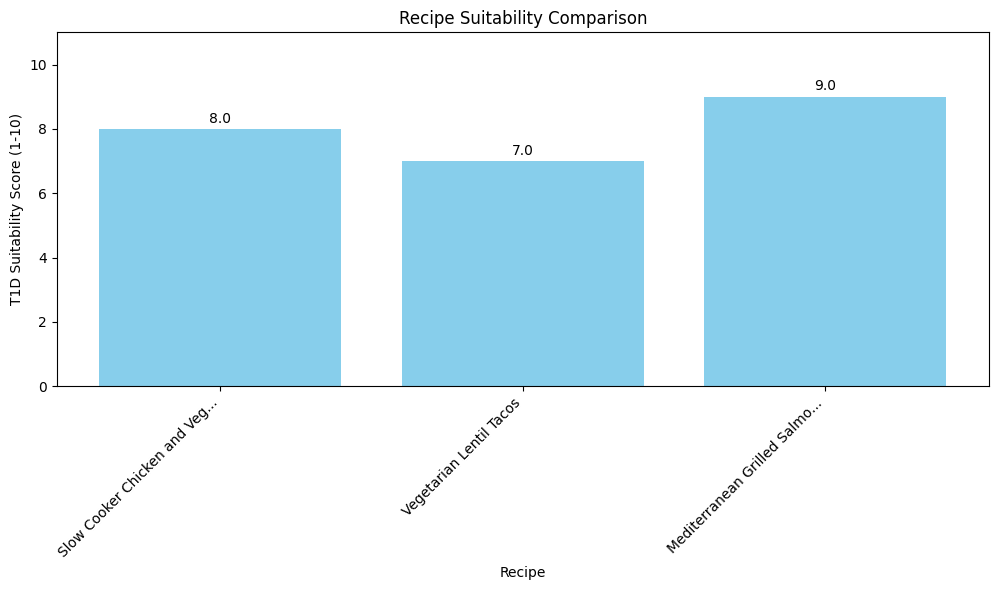

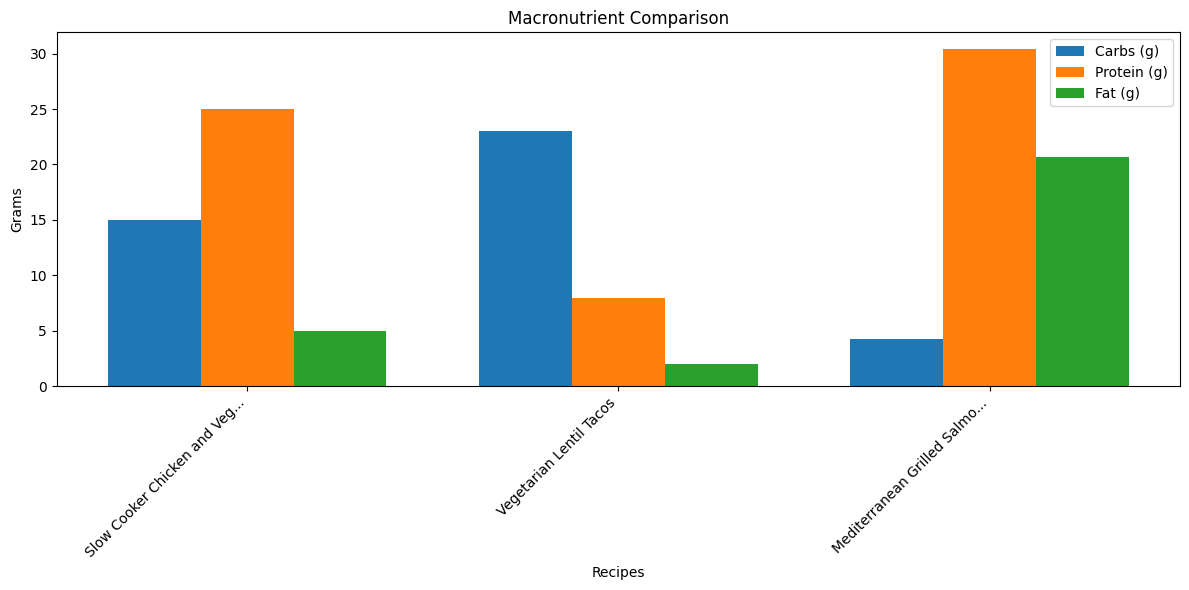

In [22]:
# run the agent
result = t1d_meal_planning_agent(sample_data_path)